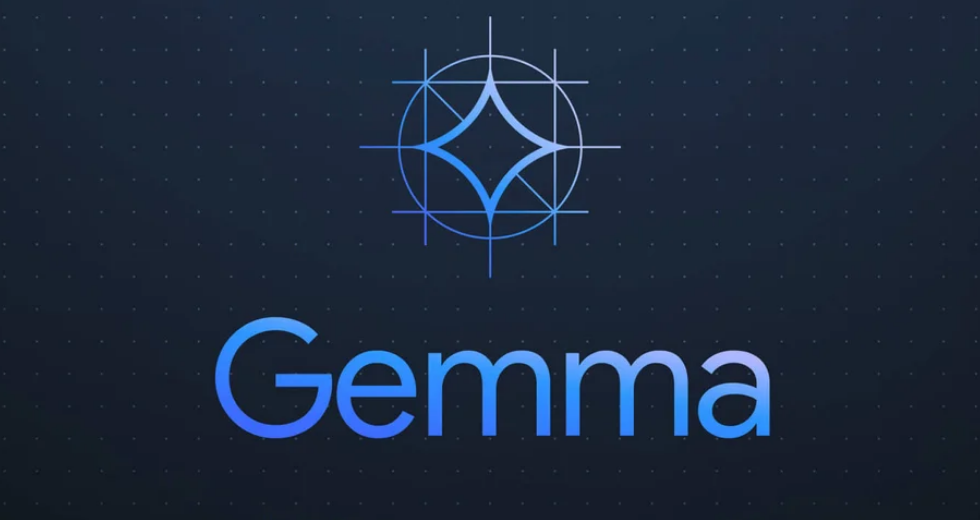

# **We will do QA in 3 steps: <br/> <br/>**

## **1. First we try QA on the Loaded model with suitable prompt without Finetune**

## **2. Fintune Gemma for our QA task and see the results**

## **3. Use RAG for context fetching for given Query and see the results with Finetuned Gemma**

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip uninstall -y bitsandbytes
!pip uninstall -y accelerate
!pip uninstall -y chromadb

Found existing installation: accelerate 0.27.2
Uninstalling accelerate-0.27.2:
  Successfully uninstalled accelerate-0.27.2


In [3]:
!pip install --quiet accelerate
!pip install --quiet bitsandbytes

In [4]:
!pip install --quiet pytorch-lightning
!pip install --quiet langchain
!pip install --quiet peft
!pip install --quiet sentence_transformers
!pip install --quiet chromadb==0.4.15

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cubinlinker, which is not installed.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires ptxcompiler, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
keras-cv 0.8.2 requires keras-core, which is not installed.
keras-nlp 0.8.1 requires keras-core, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 11.0.0 which is incompatible.
cudf

In [5]:
import json
import pandas as pd
import numpy as np
from transformers import BitsAndBytesConfig
from pathlib import Path
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split
from termcolor import colored
import textwrap

In [6]:
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

## **Load the QA Dataset**

In [7]:
path = '/kaggle/input/newsqa/NewsQA.feather'

In [8]:
df = pd.read_feather(path)
df.head(5)

,question,answer,paragraph
0,Who is the managing director of Synergee Capital?,Vikram Dalal,"""Investors can use a combination of governmen..."
1,What is the yield of 30- and 40-year governmen...,7%,"""Investors can use a combination of governmen..."
2,What is the name of the ETF 2027 that a conser...,SDL,"According to financial planners, an example o..."
3,When would a conservative fixed income investo...,2027,"According to financial planners, an example o..."
4,What year would a conservative fixed income in...,2040,"According to financial planners, an example o..."


In [9]:
df = df.iloc[:500]

In [10]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorWithPadding

2024-04-01 18:02:10.959615: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 18:02:10.959720: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 18:02:11.107114: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Gemma 2b instruct**

## **1. First we try QA on the Loaded model with suitable prompt and see the Results** 

## **Load the Model and Tokenizer**

In [11]:
MODEL_NAME = "/kaggle/input/gemma/transformers/2b-it/2"

In [12]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [13]:
import torch
from torch import cuda, bfloat16
import transformers
from peft import LoraConfig, get_peft_model, TaskType

In [14]:
model_config = transformers.AutoConfig.from_pretrained(MODEL_NAME)

### **Config to Load the Model**

In [15]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=bfloat16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

In [16]:
init_model = AutoModelForCausalLM.from_pretrained(MODEL_NAME,
                                              trust_remote_code=True,
                                              config=model_config,
                                              quantization_config=quantization_config,
                                              device_map='auto')
                                                           

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [17]:
from transformers import AutoTokenizer, pipeline, logging, TextStreamer


In [18]:
from langchain.llms import HuggingFacePipeline


In [19]:
streamer = TextStreamer(tokenizer,
                        skip_prompt = True,
                        skip_special_tokens = True)


text_pipeline = pipeline(task = 'text-generation',
                         model = init_model,
                         tokenizer = tokenizer,
                         temperature=0.5,  # 'randomness' of outputs, 0.0 is the min and 1.0 the max
                         top_p=0.25,  # select from top tokens whose probability add up to 15%
                         top_k=0,  # select from top 0 tokens (because zero, relies on top_p)
                         max_new_tokens=200,  # mex number of tokens to generate in the output
                         repetition_penalty=1.1,  # without this output begins repeating
                         streamer = streamer)


llm = HuggingFacePipeline(pipeline = text_pipeline)

In [20]:
from langchain.prompts import PromptTemplate


In [21]:
template = """
    Use following piece of context to answer the question in less than 30 words.

    Context : {context}

    Question : {question}

    Answer : """

In [22]:
prompt = PromptTemplate(template=template,
                        input_variables=["context", "question"])

In [23]:
chain_type_kwargs = {"prompt": prompt}

# **RAG**

### **3.a : Spliiting the context text before generating the Embeddings**

In [24]:
from langchain.document_loaders import TextLoader
from langchain.text_splitter import SentenceTransformersTokenTextSplitter,TokenTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA


In [25]:
from langchain_community.document_loaders import DataFrameLoader


In [26]:
loader = DataFrameLoader(df, page_content_column="paragraph")


In [27]:
documents = loader.load_and_split()


In [28]:
!pip install --quiet tiktoken

In [29]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [30]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1500,
                                               chunk_overlap=150)


all_splits = text_splitter.split_documents(documents)

### **3.b : Generate Embeddings on splitted text using SentenceTransformer**

In [31]:
model_name = "hkunlp/instructor-large"
model_kwargs = {"device": "cuda"}

embeddings = HuggingFaceEmbeddings(model_name=model_name, model_kwargs=model_kwargs)

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/66.3k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.41k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.15M [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

### **3.c : Storing the Embeddings in CromaDB**

In [32]:
from langchain.vectorstores import Chroma

In [33]:
vectordb = Chroma.from_documents(documents=all_splits, 
                                 embedding=embeddings, 
                                 persist_directory="chroma_db")

### **Specifying no of docs it will return for a given query**

In [34]:
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vectordb.as_retriever(search_kwargs={"k": 5}),
    return_source_documents = True,
    chain_type_kwargs=chain_type_kwargs,
)

In [36]:
question = df.iloc[0]['question']
print(question)

Who is the managing director of Synergee Capital?


In [44]:
def predict(idx):
    question = df.iloc[idx]['question']
    print("\nQuestion : ",question)
    print("\nActual : ",df.iloc[idx]['answer'])
    print("\nPredicted : ")
    result = qa_chain(question)

In [45]:
predict(0)


Question :  Who is the managing director of Synergee Capital?

Actual :  Vikram Dalal

Predicted : 

    The question cannot be answered from the context, as the information about the managing director of Synergee Capital is not provided in the context.


In [47]:
predict(50)


Question :  Which company clocked $2 billion in GMV in calendar 2020?

Actual :  Myntra

Predicted : 
2 billion in GMV was clocked by Myntra in calendar 2020.
